In [107]:
import copy
import numpy as np
from queue import PriorityQueue
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from multiprocessing import Pool
import multiprocess_f1_score as mfs
import time

### 공통 함수

In [2]:
# 깊이 우선 탐색
def dfs(v, X):
    stack = [v]
    visited = np.zeros((len(X)), dtype=bool)
    while stack:
        v = stack.pop()
        visited[v] = True
        for neig in np.where(X[v])[0]:
            if visited[neig] == False:
                stack.append(neig)
    return visited


# 그래프 분할 함수
def split_graph(X):
    cluster = list()
    visited = np.zeros((len(X)), dtype=bool)
    for i in range(len(X)):
        if visited[i] == False:
            v = dfs(i, X)
            visited[v] = True
            cluster.append(v)
    return np.array(cluster)


# 분할된 그래프로 클러스터 생성 함수
def split_grpah_to_cluster(split):
    cluster = np.zeros((split.shape[1]), dtype=np.int32)
    for i, s in enumerate(split):
        cluster[s] = i
    return cluster, i


# 거리 벡터 함수
def distance_vector(X, v):
    distance = np.full(len(X[v]),np.inf)
    distance[v] = 0
    que = PriorityQueue()
    que.put((0, v))
    while que.empty() == False:
        i = que.get()
        d = np.where(X[i[1]], i[0]+1, np.inf)
        d = np.stack((distance, d), axis=-1)
        distance = np.min(d, axis=-1)
        for j in np.where(np.argmin(d, axis=-1))[0]:
            que.put((distance[j], j))
    return distance


def graph_distance_matrix(X):
    distance_matrix = np.where(X == 1, 1, np.inf)
    cond = np.arange(len(X))
    distance_matrix[cond, cond] = 0
    
    que = PriorityQueue()
    for i in range(len(X)):
        que.put((1, i))
    
    while que.empty() == False:
        i = que.get()
        print(f'\r{i[0]} {i[1]}', end='')
        tmp_matrix = distance_matrix[i[1]] + distance_matrix
        tmp_matrix = np.min(tmp_matrix, axis=-1)
        tmp_matrix = np.stack((distance_matrix[i[1]], tmp_matrix), axis=-1)
        min_distance = np.min(tmp_matrix, axis=-1)
        distance_matrix[i[1]] = min_distance
        distance_matrix[:, i[1]] = min_distance
        for j in np.where(np.argmin(tmp_matrix, axis=-1))[0]:
            que.put((distance_matrix[i[1], j], j))
    return distance_matrix


def generate_cluster_matrix(y):
    cluster_matrix = list()
    for i in np.unique(y):
        if i == -1:
            break
        cluster_matrix.append(np.where(y == i, 1, 0))
    return np.array(cluster_matrix)


def super_cluster_matrix(sub_cluster_matrix, sub):
    cluster_matrix = np.zeros((len(sub_cluster_matrix), len(sub)), dtype=np.int32)
    cluster_matrix[:, sub] = sub_cluster_matrix
    return cluster_matrix


def sorting_vector(vector, label):
    sort = np.argsort(label)
    return vector[sort], label[sort]


def sorting_matrix(matrix, label):
    sort = np.argsort(label)
    return matrix[sort][:, sort], label[sort]


def sorting_cluster_matrix(cluster_matrix, label):
    sort = np.argsort(label)
    return cluster_matrix[:, sort], label[sort]


def extend_vector(X, label, target_label):
    tmp_label = np.array(list(set(target_label) - set(label)))
    con_label = np.concatenate((label, tmp_label))
    tmp = np.zeros(len(tmp_label), dtype=np.int32)
    con = np.concatenate((X, tmp))
    return con, con_label


def extend_matrix(X, label, target_label):
    tmp_label = np.array(list(set(target_label) - set(label)))
    con_label = np.concatenate((label, tmp_label))
    tmp = np.zeros((len(tmp_label), len(label)), dtype=np.int32)
    con = np.concatenate((X, tmp))
    tmp = np.zeros((len(con_label), len(tmp_label)), dtype=np.int32)
    con = np.concatenate((con, tmp), axis=-1)
    return con, con_label


def extend_cluster_matrix(X, label, target_label):
    tmp_label = np.array(list(set(target_label) - set(label)))
    con_label = np.concatenate((label, tmp_label))
    tmp = np.zeros((len(X), len(tmp_label)), dtype=np.int32)
    con = np.concatenate((X, tmp), axis=-1)
    return con, con_label

### 파일 읽기

In [3]:
# 파일 읽기 함수
# 파일에서 그래프 데이터를 가져오는 함수
# Parameter
#  * filename: 읽어올 파일
# Return: data dictionary 데이터
def get_input_data(filename):
    input_file = open(filename, 'r')
    data = dict()
    for line in input_file:
        splitted = line.split()

        if splitted[0] in data:
            data[splitted[0]].add(splitted[1])
        else:
            data[splitted[0]] = set([splitted[1]])

        if splitted[1] in data:
            data[splitted[1]].add(splitted[0])
        else:
            data[splitted[1]] = set([splitted[0]])

    return data


data_dict = get_input_data('project_input.txt')

In [4]:
def get_ground_truth_data(filename):
    input_file = open(filename, 'r')
    
    cluster = list()
    label = set()
    for idx, line in enumerate(input_file):
        splitted = line.split()
        label.update(splitted)
        cluster.append(splitted)
    label = np.sort(np.array(list(label)))
    cluster_matrix = list()
    for c in cluster:
        ext_vector, ext_label = extend_vector(np.ones(len(c), dtype=np.int32), c, label)
        sort, _ = sorting_vector(ext_vector, ext_label)
        cluster_matrix.append(sort)
    return np.array(cluster_matrix), label
        
hierachical_cluster_matrix, hierachical_label = get_ground_truth_data('assignment6_output.txt')
true_cluster_matrix, true_label = get_ground_truth_data('project_target.txt')

### Matrix 생성

In [5]:
# 인접행렬 생성 함수
# 그래프 딕셔너리로 인접행렬을 생성하는 함수
# Parameter
#  * graph: 그래프 딕셔너리
# Return: 인접행렬
def generate_graph_matrix(graph):
    matrix = np.zeros((len(data_dict), len(data_dict)), dtype=np.int32)
    label = np.array(list(graph.keys()))
    index = dict(zip(label, list(range(len(graph)))))
    for node1 in graph:
        for node2 in graph[node1]:
            matrix[index[node1], index[node2]] = 1
    return matrix, label
    
    
matrix, label = generate_graph_matrix(data_dict)

In [6]:
matrix, label = extend_matrix(matrix, label, true_label)
matrix, label = sorting_matrix(matrix, label)
hierachical_cluster_matrix, hierachical_label = extend_cluster_matrix(hierachical_cluster_matrix, hierachical_label, label)
hierachical_cluster_matrix, hierachical_label = sorting_cluster_matrix(hierachical_cluster_matrix, hierachical_label)
true_cluster_matrix, true_label = extend_cluster_matrix(true_cluster_matrix, true_label, label)
true_cluster_matrix, true_label = sorting_cluster_matrix(true_cluster_matrix, true_label)

print(matrix.shape)
print(hierachical_cluster_matrix.shape)
print(true_cluster_matrix.shape)

(3343, 3343)
(78, 3343)
(734, 3343)


### 확률 행렬

In [7]:
def generate_probability_matrix(cluster):
    probability_matrix = np.zeros((cluster.shape[1], cluster.shape[1]))
    for i in range(cluster.shape[1]):
        cond = cluster[:, i] == 1
        if True in cond:
            probability_matrix[i] = np.mean(cluster[cond], axis=0)
    return probability_matrix

def cluster_from_probability_matrix(probability_matrix, threshold, min_cluster_size=2, max_cluster_size=20):
    test = probability_matrix[:20, :20]
    cluster = np.unique(np.where(probability_matrix > threshold, 1, 0), axis=0)
    test_cluster = np.unique(np.where(test > threshold, 1, 0), axis=0)
    cluster_size = np.sum(cluster, axis=-1)
    test_cluster_size = np.sum(test_cluster, axis=-1)
    cond = (cluster_size >= min_cluster_size) & (cluster_size <= max_cluster_size)
    test_cond = (test_cluster_size >= min_cluster_size) & (test_cluster_size <= max_cluster_size)
    return cluster[cond]

#k_core_probability_matrix = generate_probability_matrix(pred_k_core_cluster_matrix)
#variable_k_core_probability_matrix = generate_probability_matrix(pred_variable_k_core_cluster_matrix)

### F1 Score

In [47]:
def incidient_matrix_f_score_matrix(y_true, y_pred):
    f_score_matrix = np.zeros((len(y_pred), len(y_true)), dtype=np.float64)
    args = list()
    
    for pidx, p in enumerate(y_pred):
        for tidx, t in enumerate(y_true):
            args.append([t, p])
            
    pool = Pool(8)
    ret = pool.map(mfs.f1_score_multiprocess, args)
    ret = iter(ret)
    for pidx in range(len(y_pred)):
        for tidx in range(len(y_true)):
            f_score_matrix[pidx, tidx] = next(ret)
    pool.close()
    pool.join()
    
    return f_score_matrix

def incidient_matrix_f_score(f_score_matrix):
    f_score_max = np.max(f_score_matrix, axis=-1)
    f_score = np.mean(f_score_max)
    return f_score

def incidient_matrix_f_score_reverse(f_score_matrix):
    f_score_max = np.max(f_score_matrix, axis=0)
    f_score = np.mean(f_score_max)
    return f_score

def f_measure(cluster, string, start_time):
    f_score_matrix = incidient_matrix_f_score_matrix(true_cluster_matrix, cluster)
    f_score = incidient_matrix_f_score(f_score_matrix)
    f_score_reverse = incidient_matrix_f_score_reverse(f_score_matrix)
    print(f'{string:>8}: {time.time() - start_time:>6.2f}s {len(cluster):>4d} {f_score * 100:>5.2f}% {f_score_reverse * 100:>5.2f}%')

def measure_probability_matrix(cluster_matrix, min_cluster_size=2, max_cluster_size=100):
    start_time = time.time()
    probability_matrix = generate_probability_matrix(cluster_matrix)
    print(f'Probability Matrix Time: {time.time() - start_time:.2f}s')
    print()

    f_measure(cluster_matrix, 'original', time.time())
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]:
        start_time = time.time()
        cluster = cluster_from_probability_matrix(probability_matrix, threshold, min_cluster_size=min_cluster_size, max_cluster_size=max_cluster_size)
        if len(cluster) > 0:
            f_measure(cluster, str(threshold), start_time)

### 좌표 기반의 군집화

In [126]:
def graph_to_coordinate(X, core, core_multiple):
    X_degree = np.sum(X, axis=-1)
    candidate_index = np.argsort(X_degree)[:core * core_multiple]
    
    candidate_distance_vector = []
    for i in candidate_index:
        candidate_distance_vector.append(distance_vector(X, i))
    candidate_distance_vector = np.array(candidate_distance_vector)
    
    candidate_distance_matrix = candidate_distance_vector[:, candidate_index]
    
    origin = np.zeros_like(candidate_index, dtype=bool)
    origin[np.argmax(np.sum(candidate_distance_matrix, axis=-1))] = True
    for i in range(core - 1):
        origin_distance_vector = candidate_distance_matrix[origin]
        mask_distance_vector = np.where(origin, -np.inf, 0).reshape(1, -1)
        vector = np.concatenate((origin_distance_vector, mask_distance_vector), axis=0)
        origin[np.argmax(np.sum(vector, axis=0))] = True   
    return candidate_distance_vector[origin].T


def graph_to_coordinate_PCA(X):
    X_degree = np.sum(X, axis=-1)
    candidate_index = np.argsort(X_degree)[:len(X) // 40]
    
    candidate_distance_vector = []
    for i in candidate_index:
        candidate_distance_vector.append(distance_vector(X, i))
    candidate_distance_vector = np.array(candidate_distance_vector)
    
    pca = PCA(n_components=0.9)
    pca_distance_matrix = pca.fit_transform(candidate_distance_vector.T)
    
    return pca_distance_matrix


def k_means_cluster_matrix(X, clusters):
    cluster_matrix = list()
    for i in clusters:
        cluster = KMeans(n_clusters=i).fit(X).labels_
        cluster_matrix.extend(generate_cluster_matrix(cluster))
    return cluster_matrix


def hierarchical_cluster_matrix(X, clusters):
    cluster_matrix = list()
    for i in clusters:
        cluster = AgglomerativeClustering(n_clusters=i).fit(X).labels_
        cluster_matrix.extend(generate_cluster_matrix(cluster))
    return cluster_matrix


def birch_cluster_matrix(X, clusters):
    cluster_matrix = list()
    cluster = Birch(n_clusters=None).fit_predict(X)
    cluster_matrix.extend(generate_cluster_matrix(cluster))
    for i in clusters:
        cluster = Birch(n_clusters=i).fit_predict(X)
        cluster_matrix.extend(generate_cluster_matrix(cluster))
    return cluster_matrix


def spectral_cluster_matrix(X, clusters):
    cluster_matrix = list()
    for i in clusters:
        cluster = SpectralClustering(n_clusters=i).fit_predict(X)
        cluster_matrix.extend(generate_cluster_matrix(cluster))
    return cluster_matrix


def coordinate_based_graph_clustering(X, clusters=range(2, 10)):
    cluster_matrix = list()
    for sub in split_graph(X):
        if np.sum(sub) < 20:
            continue
            
        start_time = time.time()
        coordinate = graph_to_coordinate_PCA(X[sub][:, sub])
        print(f'PCA: {time.time() - start_time:.2f}s')

        #start_time = time.time()
        #sub_cluster_matrix = k_means_cluster_matrix(coordinate, clusters)
        #sub_cluster_matrix = super_cluster_matrix(sub_cluster_matrix, sub)
        #cluster_matrix.extend(sub_cluster_matrix)
        #print(f'KMeans: {time.time() - start_time:.2f}s')

        #start_time = time.time()
        #sub_cluster_matrix = hierarchical_cluster_matrix(coordinate, clusters)
        #sub_cluster_matrix = super_cluster_matrix(sub_cluster_matrix, sub)
        #cluster_matrix.extend(sub_cluster_matrix)
        #print(f'Hierarchical: {time.time() - start_time:.2f}s')

        #start_time = time.time()
        #sub_cluster_matrix = birch_cluster_matrix(coordinate, clusters)
        #sub_cluster_matrix = super_cluster_matrix(sub_cluster_matrix, sub)
        #cluster_matrix.extend(sub_cluster_matrix)
        #print(f'Birch: {time.time() - start_time:.2f}s')
        
        start_time = time.time()
        sub_cluster_matrix = spectral_cluster_matrix(coordinate[:, :3], clusters)
        sub_cluster_matrix = super_cluster_matrix(sub_cluster_matrix, sub)
        cluster_matrix.extend(sub_cluster_matrix)
        print(f'Spectral: {time.time() - start_time:.2f}s')
    cluster_matrix = np.array(cluster_matrix)
    cluster_matrix = np.unique(cluster_matrix, axis=0)
    cluster_matrix = cluster_matrix[np.sum(cluster_matrix, axis=-1) > 1]
    return cluster_matrix
            
start_time = time.time()
pred_coord_cluster_matrix = coordinate_based_graph_clustering(matrix, clusters=range(2, 30, 2))
print(f'Total: {time.time() - start_time:.2f}s')
print(f'Cluster: {len(pred_coord_cluster_matrix)}')

PCA: 9.57s
Spectral: 38.19s
Total: 48.14s
Cluster: 63


In [127]:
measure_probability_matrix(pred_coord_cluster_matrix, min_cluster_size=3, max_cluster_size=10)

Probability Matrix Time: 0.17s

original:   2.08s   63 21.66%  2.76%
     0.1:   2.34s    1 50.00%  0.20%
     0.2:   2.34s    1 50.00%  0.20%
     0.3:   2.31s    1 50.00%  0.20%
     0.4:   2.11s    1 50.00%  0.20%
     0.5:   2.06s    2 71.43%  0.33%
     0.6:   1.94s    2 71.43%  0.33%
     0.7:   2.06s    4 45.81%  0.42%
     0.8:   2.14s    9 41.66%  0.92%
     0.9:   2.24s   14 38.95%  1.24%
    0.95:   2.31s   16 35.47%  1.29%
    0.99:   2.27s   16 35.47%  1.29%


In [27]:
measure_probability_matrix(hierachical_cluster_matrix, min_cluster_size=3, max_cluster_size=10)

Probability Matrix Time: 0.02s

original:   3.43s   78 41.81%  5.77%
     0.1:   3.64s   18 55.49%  2.27%
     0.2:   3.27s   18 55.49%  2.27%
     0.3:   3.44s   18 55.49%  2.27%
     0.4:   3.53s   18 55.49%  2.27%
     0.5:   3.34s   18 55.49%  2.27%
     0.6:   3.24s   18 55.49%  2.27%
     0.7:   3.46s   18 55.49%  2.27%
     0.8:   3.31s   18 55.49%  2.27%
     0.9:   3.29s   18 55.49%  2.27%
    0.95:   3.32s   18 55.49%  2.27%
    0.99:   3.29s   18 55.49%  2.27%


### Dense 기반의 군집화

In [19]:
def k_core_graph_clustering(X, density, max_iter=100, copy_X=True):
    if copy_X:
        X = X.copy()
    
    for i in range(max_iter):
        pre_X = X.copy()
        X_density = np.sum(X, axis=-1)
        cond = X_density < density
        X[cond, :] = 0
        X[:, cond] = 0
        if np.all(pre_X == X):
            break
    
    splitted = split_graph(X)
    cond = np.sum(splitted, axis=-1) > 1
    return splitted[cond].astype(np.int32)


def variable_k_core_graph_clustering(X, max_density=100, max_iter=100, copy_X=True):
    if copy_X:
        X = X.copy()
        
    cluster = list()
    for density in range(max_density):
        c = k_core_graph_clustering(X, density, max_iter)
        if len(c) == 0:
            break
        else:
            cluster.extend(c)
    
    return np.unique(np.array(cluster), axis=0)


pred_k_core_cluster_matrix = k_core_graph_clustering(matrix, 3)
pred_variable_k_core_cluster_matrix = variable_k_core_graph_clustering(matrix)

In [28]:
measure_probability_matrix(pred_k_core_cluster_matrix, min_cluster_size=3, max_cluster_size=10)

Probability Matrix Time: 0.04s

original:   0.81s    3 65.51%  0.72%
     0.1:   2.66s    2 94.44%  0.35%
     0.2:   2.76s    2 94.44%  0.35%
     0.3:   2.77s    2 94.44%  0.35%
     0.4:   2.64s    2 94.44%  0.35%
     0.5:   2.64s    2 94.44%  0.35%
     0.6:   2.67s    2 94.44%  0.35%
     0.7:   2.56s    2 94.44%  0.35%
     0.8:   2.67s    2 94.44%  0.35%
     0.9:   2.77s    2 94.44%  0.35%
    0.95:   2.67s    2 94.44%  0.35%
    0.99:   2.77s    2 94.44%  0.35%


In [128]:
measure_probability_matrix(pred_variable_k_core_cluster_matrix, min_cluster_size=3, max_cluster_size=10)

Probability Matrix Time: 0.10s

original:   3.00s   91 41.86%  7.03%
     0.1:   2.84s   17 55.63%  2.11%
     0.2:   2.63s   17 55.63%  2.11%
     0.3:   2.61s   17 55.63%  2.11%
     0.4:   2.56s   17 55.63%  2.11%
     0.5:   2.50s   20 56.44%  2.16%
     0.6:   2.49s   20 56.44%  2.16%
     0.7:   2.57s   20 56.44%  2.16%
     0.8:   2.48s   21 58.08%  2.40%
     0.9:   2.50s   24 60.17%  2.76%
    0.95:   2.50s   24 60.17%  2.76%
    0.99:   2.50s   24 60.17%  2.76%


In [129]:
mix_cluster_matrix = list()
mix_cluster_matrix.extend(pred_coord_cluster_matrix)
mix_cluster_matrix.extend(hierachical_cluster_matrix)
mix_cluster_matrix.extend(pred_variable_k_core_cluster_matrix)
mix_cluster_matrix = np.array(mix_cluster_matrix)

In [130]:
measure_probability_matrix(mix_cluster_matrix, min_cluster_size=3, max_cluster_size=10)

Probability Matrix Time: 0.19s

original:   8.02s  232 36.36%  9.45%
     0.1:   2.47s   17 55.63%  2.11%
     0.2:   2.43s   17 55.63%  2.11%
     0.3:   2.40s   17 55.63%  2.11%
     0.4:   2.23s   20 53.78%  2.34%
     0.5:   2.17s   23 54.47%  2.42%
     0.6:   2.14s   23 54.47%  2.42%
     0.7:   2.35s   29 54.15%  2.86%
     0.8:   2.65s   39 49.82%  3.33%
     0.9:   3.09s   54 50.45%  4.66%
    0.95:   3.38s   65 47.90%  5.47%
    0.99:   3.48s   66 48.03%  5.63%


### Test

In [21]:
test = np.array([[0, 1, 1, 1, 0, 0, 0],
                 [1, 0, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0, 0],
                 [1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1, 0, 1],
                 [0, 0, 0, 0, 0, 1, 0]], dtype=bool)

test_sub = [True, True, True, True, False, False, False]

test_incidient_matrix = np.array([[1, 1, 1, 1],
                                  [1, 1, 1, 1],
                                  [1, 1, 1, 1],
                                  [1, 1, 1, 1]])

test_label = np.array([1, 0, 2, 3, 5, 9, 6])

tmp_incidient_matrix = np.zeros((len(test), np.sum(test_sub)))
tmp_incidient_matrix[test_sub] = test_incidient_matrix
incidient_matrix = np.zeros_like(test)
incidient_matrix[test_sub] = tmp_incidient_matrix.T
incidient_matrix

np.unique(incidient_matrix, axis=0)
sorting_matrix(test, test_label)

(array([[False,  True,  True, False, False, False, False],
        [ True, False,  True,  True, False, False, False],
        [ True,  True, False, False, False, False, False],
        [False,  True, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [False, False, False, False, False, False,  True],
        [False, False, False, False,  True,  True, False]]),
 array([0, 1, 2, 3, 5, 6, 9]))

In [22]:
test_cluster = np.unique(variable_k_core_graph_clustering(test), axis=0)
test_probability_matrix = generate_probability_matrix(test_cluster)
test_probability_matrix = np.array([
    [1, 0.5, 0.3, 0, 0],
    [0.1, 1, 0, 0.4, 0],
    [0.5, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1]
])
cluster_from_probability_matrix(test_probability_matrix, 0.6)

array([], shape=(0, 5), dtype=int32)

In [23]:
test1 = np.array([1, 1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 1, 1, 1])

TypeError: array() takes from 1 to 2 positional arguments but 7 were given

In [ ]:
extend_matrix(test, test_label, test_true_label)

In [ ]:
def jaccard_coefficient(x, y):
    union = np.sum(x | y, axis=-1)
    inter = np.sum(x & y, axis=-1)
    
    if union == 2:
        return 1
    else:
        return inter / (union - 2)    
    
def jaccard_matrix(X):
    X = X.copy()
    matrix = np.full((len(X), len(X)), np.inf, dtype=np.float)
    for i in range(len(X)):
        for j in range(len(X) - i - 1):
            j = i + j + 1
            
            if X[i, j]:
                matrix[i, j] = matrix[j, i] = jaccard_coefficient(X[i], X[j])
    return matrix

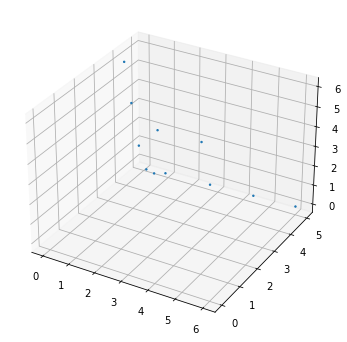

In [45]:
import matplotlib.pyplot as plt

def plot_3d_scatter(X, figsize=(6, 6), s=2, alpha=1,
                    xlim3d=None, ylim3d=None, zlim3d=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')

    ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', s=s, alpha=alpha)

    if xlim3d is not None:
        ax.set_xlim3d(xlim3d[0], xlim3d[1])
    if ylim3d is not None:
        ax.set_ylim3d(ylim3d[0], ylim3d[1])
    if zlim3d is not None:
        ax.set_zlim3d(zlim3d[0], zlim3d[1])
        
test = np.array([[0, 4, 6],
                 [1, 3, 5],
                 [2, 2, 4],
                 [3, 1, 4],
                 [4, 0, 5],
                 [3, 2, 3],
                 [2, 3, 4],
                 [3, 4, 3],
                 [4, 3, 2],
                 [5, 4, 1],
                 [6, 5, 0]])

plot_3d_scatter(test)